### Program to look at data files and measure time for VENUS control parameters to settle

Method:
- Watch system for 50 dt's (dt is time to measure/write one state snapshot with a 0.37 s pause in between)
- Make a change
- Watch system for 750 dt's
- (Exception: watch additional dt's when changing superconductors until change is done.  These files have length 50+(# of snapshots+0.37s until change done)+750 dt's

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime
import pytz
from scipy.signal import medfilt

plt.rcParams['figure.dpi']=150
plt.rcParams['font.family'] = 'Serif'

DATAFOLDER = "datafiles/"
IMAGEFOLDER = ""

In [3]:
def savepng(pngname): 
    plt.savefig(IMAGEFOLDER+pngname+".png", bbox_inches="tight", facecolor='w')
symbols = ['o','X','s','v','p','P','*','h','<','3','d','x','+']

In [4]:
def load_tracking(name):
    with open(name) as datafile:
        content = datafile.readlines()
        data = np.array([np.fromstring(c, sep=' ') for c in content])
    return data[:,0],data[:,1:]

def load_names(filename):
    with open(filename) as datafile:
        names = []
        nl = 0
        while datafile.readline(): nl=nl+1
        datafile.seek(0)
        for i in range(nl):
            names.append(datafile.readline()[3:])
    return names[1:]

names = load_names(DATAFOLDER + 'balzer_1673709937')  # load the names of the different columns
labels=['M/Q','fcv in',r'O$^{7+}$ [$\mu$A]','balzer 1','balzer 2','balzer 5','balzer 6','balzer 7',
        'gas 1','gas 2','gas 5','gas 6','gas 7',r'I$_\mathrm{inj}$ [A]',r'I$_\mathrm{ext}$ [A]',
        r'I$_\mathrm{mid}$ [A]',r'I$_\mathrm{sext}$ [A]',r'V$_\mathrm{inj}$ [V]',r'V$_\mathrm{ext}$ [V]',
        r'V$_\mathrm{mid}$ [V]',r'V$_\mathrm{sext}$ [V]',r'Vps$_\mathrm{inj}$ [V]',r'Vps$_\mathrm{ext}$ [V]',
        r'Vps$_\mathrm{mid}$ [V]',r'Vps$_\mathrm{sext}$ [V]',r'injection pressure [$\cdot 10^{-7}$ torr]',
        r'extraction pressure [$\cdot 10^{-7}$ torr]',r'V$_\mathrm{bias}$ [V]',r'I$_\mathrm{bias}$ [mA]',
        '18 GHz power [kW]','reflected 18 GHz power [W]','28 GHz power [kW]',r'I$_\mathrm{glaser}$ [A]',
        r'I$_\mathrm{batman}$ [A]',r'B$_\mathrm{batman}$ [gauss]','x-ray source','x-ray exit',
        r'V$_\mathrm{extraction}$ [kV]',r'I$_\mathrm{drain}$ [mA]',r'V$_\mathrm{[puller]}$ [kV]',
        r'I$_\mathrm{[puller]}$ [mA]','puller raw gap',r'beam line pressure [$\cdot 10^{-9}$ torr]',
        r'I$_\mathrm{robin}$ [A]',r'V$_\mathrm{HT-oven}$ [V]',r'I$_\mathrm{HT-oven}$ [A]','LT oven 1 set point',
        'LT oven 2 set point','LT oven 1 temp [C]','LT oven 2 temp [C]','LHe pressure [PSI]','LHe level',
        'cryo vac pressure [torr]','4K heater power [W]','4K cold mass [K]','4K cryo E [K]',
        '4K cryo W [K]','4K cryo NE [K]','4K cryo NW [K]','4K heat cond [K]','4K feedthrough [K]',
        '4K heater [K]','50K cond bar [K]','50K cond bar NE [K]','50K cond bar NW [K]','50K shield [K]',
        'bottom LN vessel [K]','70K cond bar [K]','set balz 1','set balz 2','set balz 5','set balz 6','set balz 7',
        r'set I$_\mathrm{inj}$ [A]',r'set I$_\mathrm{ext}$ [A]',r'set I$_\mathrm{mid}$ [A]',
        r'set I$_\mathrm{sext}$ [A]',r'set P$_\mathrm{18}$ [W]',r'set P$_\mathrm{28}$ [W]',
        r'set I$_\mathrm{glaser}$ [A]',r'set I$_\mathrm{batman}$ [A]',r'set V$_\mathrm{ext}$ [V]',
        r'set V$_\mathrm{puller}$ [V]',r'set I$_\mathrm{robin}$ [A]']

In [5]:
def makeline(ist,num2print,names):
    a = ''
    for i in range(num2print):
        num = str(ist+i)
        if len(num)<2: num='0'+num
        thisone = names[ist+i][:-1]
        if len(thisone)>10: thisone = thisone[:10]
        while len(thisone)<10: thisone=thisone+' '
        a = a+num+':'+thisone+' '
    return(a)
# Show list of parameters in data file and their index number
for i in range(int(len(names)/7)):
    print(makeline(i*7,7,names))   
print(makeline(int(len(names)/7)*7,len(names)-int(len(names)/7)*7,names))       

00:3709938.24 01:3709939.06 02:3709939.84 03:3709940.50 04:3709941.27 05:3709942.08 06:3709942.75 
07:3709943.41 08:3709944.24 09:3709944.91 10:3709945.62 11:3709946.43 12:3709947.10 13:3709947.77 
14:3709948.57 15:3709949.36 16:3709950.02 17:3709950.67 18:3709951.51 19:3709952.24 20:3709952.90 
21:3709953.62 22:3709954.43 23:3709955.07 24:3709955.73 25:3709956.42 26:3709957.07 27:3709957.87 
28:3709958.62 29:3709959.30 30:3709959.97 31:3709960.80 32:3709961.57 33:3709962.24 34:3709963.07 
35:3709963.83 36:3709964.49 37:3709965.22 38:3709966.04 39:3709966.71 40:3709967.36 41:3709968.14 
42:3709968.91 43:3709969.57 44:3709970.24 45:3709971.07 46:3709971.76 47:3709972.52 48:3709973.33 
49:3709975.04 50:3709975.71 51:3709976.50 52:3709977.30 53:3709978.01 54:3709978.66 55:3709979.47 
56:3709980.24 57:3709980.91 58:3709981.56 59:3709982.40 60:3709983.15 61:3709983.82 62:3709984.55 
63:3709985.37 64:3709986.05 65:3709986.73 66:3709987.51 67:3709988.30 68:3709988.97 69:3709989.62 
70:3709990

In [6]:
import glob

Text(0, 0.5, 'O$^{7+}$ [$\\mu$A]')

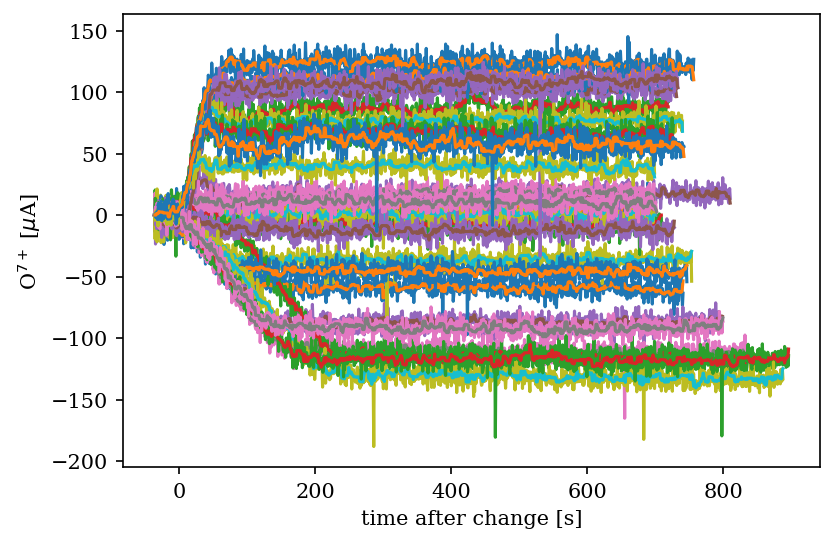

In [20]:
# raw data...no time averaging
def get_raw_data(dataset_num, yset = 2):
    """ get raw beam current data.
    dataset_number: 0:balzer, 1:28GHz, 2:18GHz 3:inj 4:ext 5:mid 6:sext 7:bias
    yset:
    2:Ibeam 25:Pinj
    68 set balz 1
    69 set balz 2 *
    70 set balz 5
    71 set balz 6
    72 set balz 7
    73 set I$_\mathrm{inj}$ [A]
    74 set I$_\mathrm{ext}$ [A]
    75 set I$_\mathrm{mid}$ [A]
    76 set I$_\mathrm{sext}$ [A]
    77 set P$_\mathrm{18}$ [W]
    78 set P$_\mathrm{28}$ [W]
    normalize: 0: not normalized, 1: normalized to t=0 value, 2: normalized to t[-1]-t[t=0] value 3: set values
    """
    filest = ['balzer_*','p28_*','p18_*','inj_*','ext_*','mid_*','sext_*',"bias_*"]
    files = []
    for file in glob.glob(DATAFOLDER+filest[dataset_num]):
        files.append(file)
    files.sort()
    
    normalize = 0
      # 0: not normalized, 1: normalized to t=0 value, 2: normalized to t[-1]-t[t=0] value
    time_series = []
    for i in range(len(files)):
        time,data = load_tracking(files[i])
        X = time-time[49]
        if normalize ==0:
            time_series.append((X, (data[:,yset]-data[0,yset])*1.0e6))
        if normalize ==1:
            time_series.append((X, (data[:,yset]-data[49,yset])/data[49,yset]*100))
        if normalize ==2:
            time_series.append((X, (data[:,yset]-data[49,yset])/(np.mean(data[-50:,yset])-data[49,yset])))
            # plt.ylim([-.1,1.1])
        if normalize ==3:
            time_series.append((X, data[:,yset]-data[0,yset]))
            
    return time_series

inj_data = get_raw_data(3)
inj_set = get_raw_data(3, 73)
ext_data = get_raw_data(4)
ext_set = get_raw_data(4, 74)
mid_data = get_raw_data(5)
mid_set = get_raw_data(4, 75)

for X, y in inj_data:
    plt.plot(X, y)
    plt.plot(X, medfilt(y, 9))
plt.xlabel('time after change [s]')
plt.ylabel(labels[2])

In [8]:
def get_set_values(set_data=inj_set):
    # get set_values in the right format for the coils
    set_values = []
    for x,y in set_data:
        set_values.append(y[500] * 1e-6) # get rid of normalization
    return set_values
print(sorted(get_set_values(inj_set)))


[-4.512, -3.842000000000013, -3.3540000000000134, -2.9879999999999995, -2.8659999999999854, -2.377999999999986, -2.257000000000005, -2.0730000000000075, -0.9139999999999873, -0.5480000000000018, -0.36599999999998545, -0.3050000000000068, -0.18299999999999272, 0.06099999999997862, 0.06100000000000705, 0.3660000000000138, 0.9749999999999942, 1.2199999999999989, 1.2810000000000057, 1.3409999999999798, 2.256, 2.257000000000005, 2.805000000000007, 3.2930000000000064, 3.7189999999999936, 3.962999999999994]


### Questions:
1. balz_1 to balz_7?
2. why are there two steps in set values?

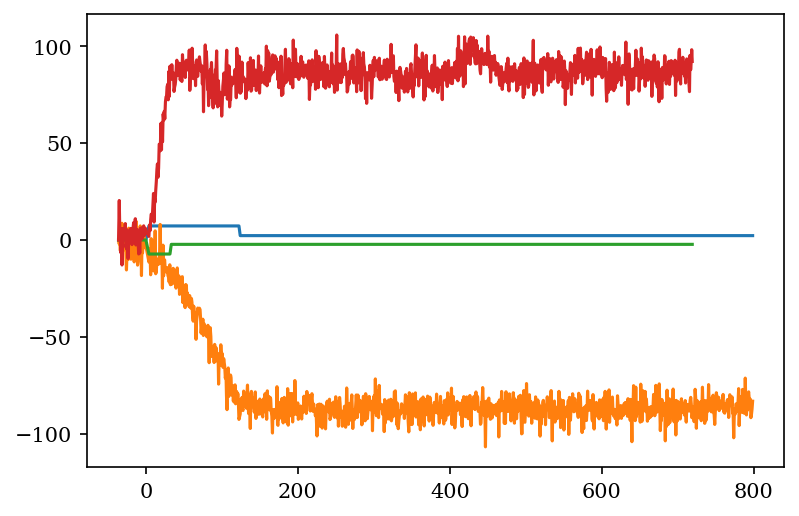

In [23]:
set_data = get_raw_data(3, 73)

i = 2
setx, sety = set_data[i]
plt.plot(setx, sety*1e-6)
tempx, tempy = inj_data[i]
plt.plot(tempx, tempy)
# print(sety[49:])

i = 1
setx, sety = set_data[i]
plt.plot(setx, sety*1e-6)
tempx, tempy = inj_data[i]
plt.plot(tempx, tempy)
# print(sety[49:])



#### Data Analysis Notes:
1. Looks like there's some data cleaning todo for extreme values
2. Needs to find the stable beam current first. Needs to pick a period where we think the beam is stable. This can only be done manually

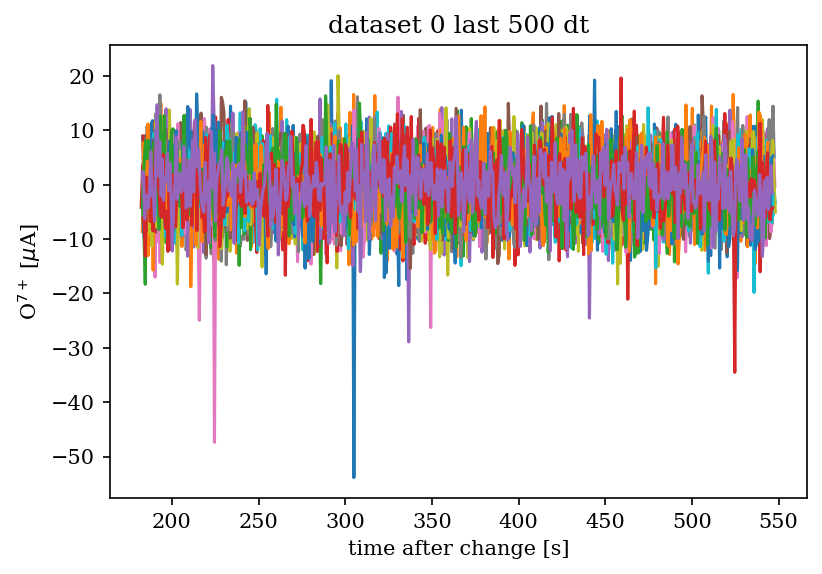

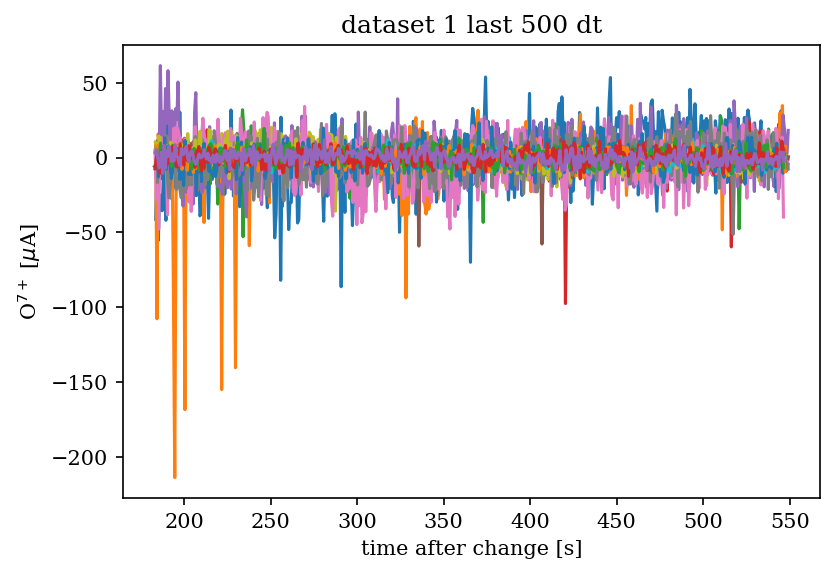

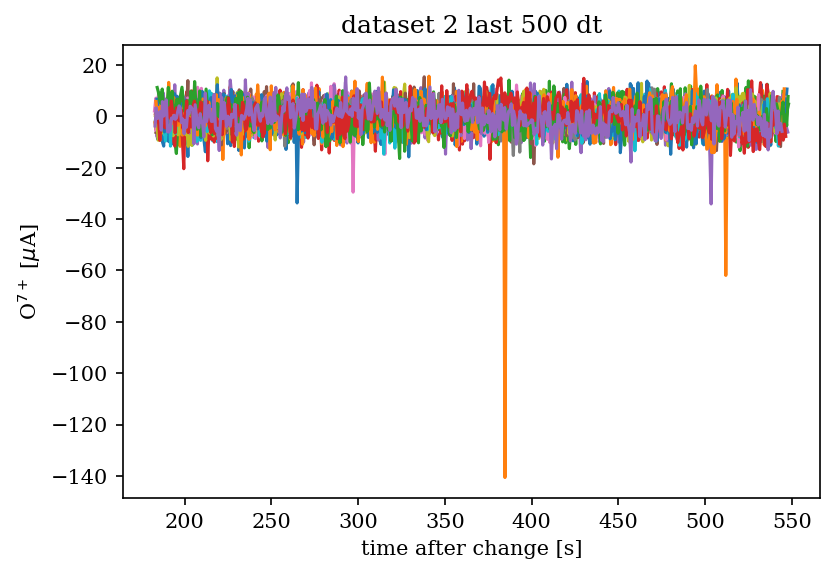

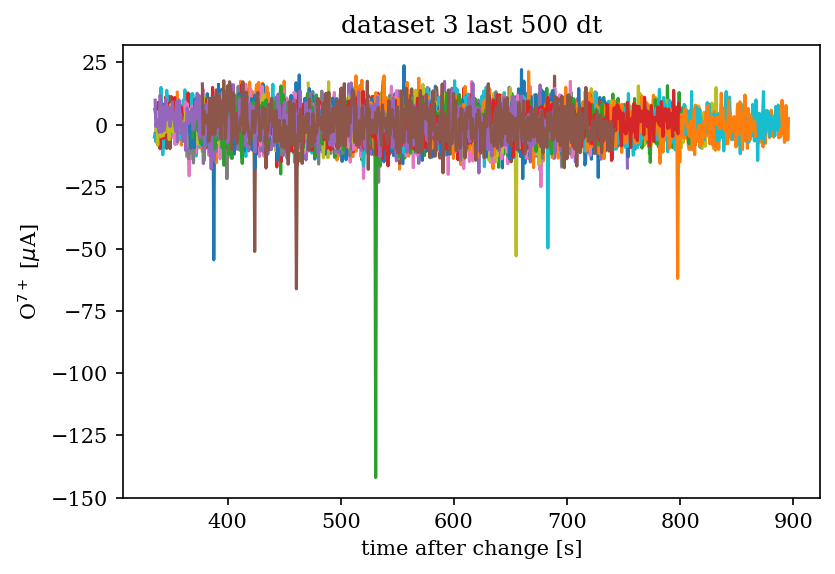

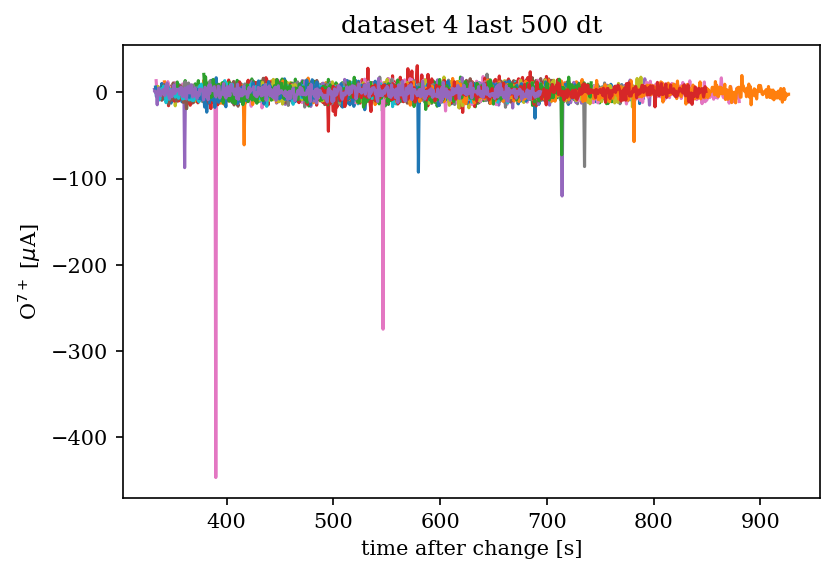

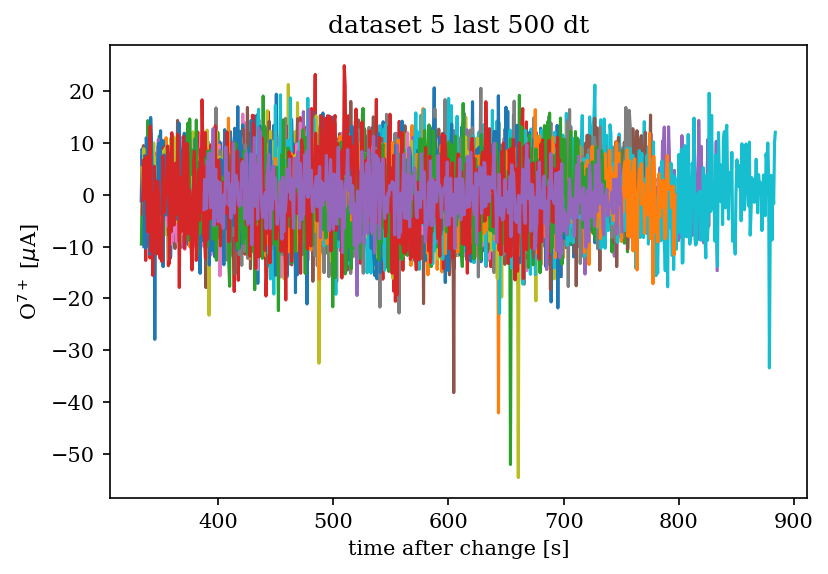

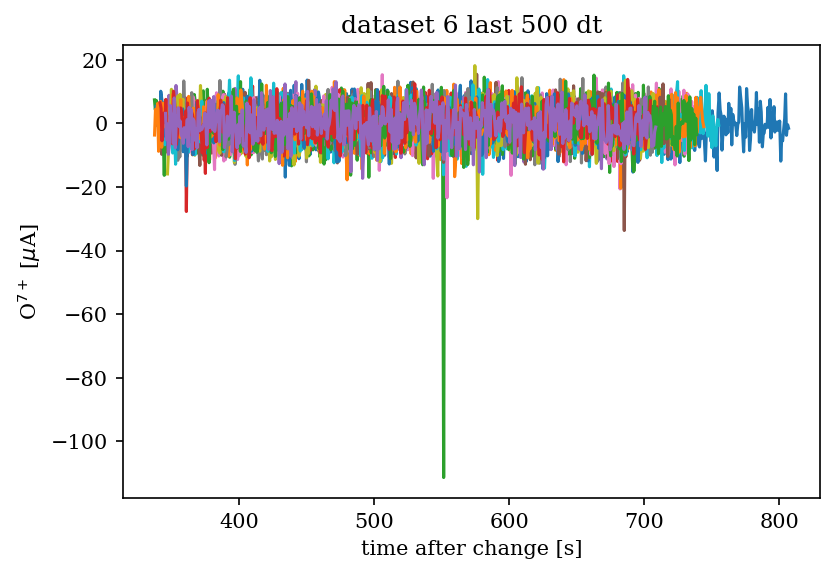

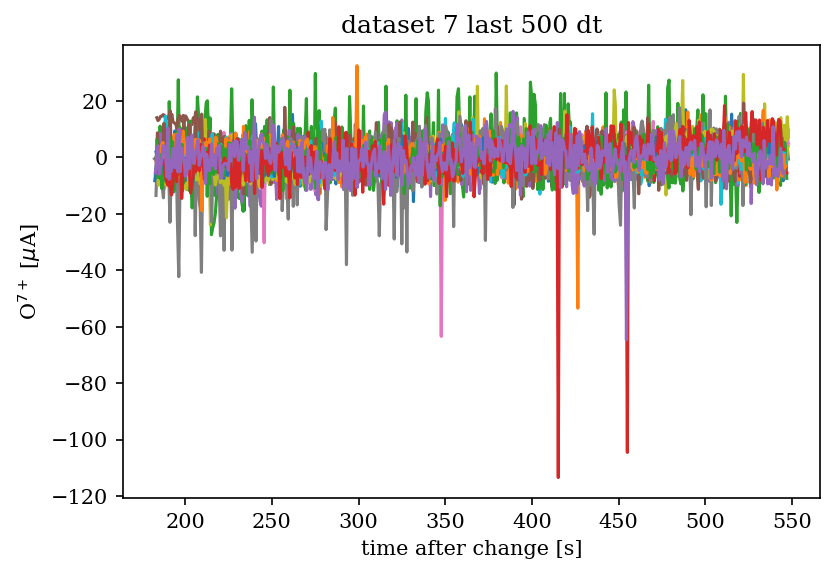

In [10]:
LAST_N = 500
for i in range(8):
    for X, y in get_raw_data(i):
        plt.plot(X[-LAST_N:], y[-LAST_N:] - np.mean(y[-LAST_N:]))
    plt.title("dataset %d last %d dt"%(i, LAST_N))
    plt.xlabel('time after change [s]')
    plt.ylabel(labels[2])
    plt.show()

From visual inspection, last 500 dt is a good. (Could fit a linear regression line to it and check the slope if publishing)

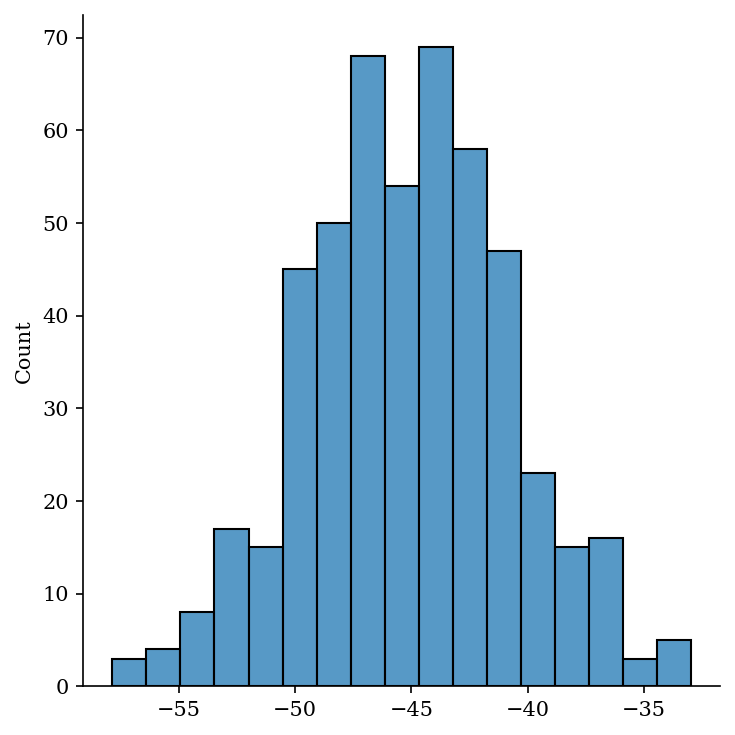

/usr/local/anaconda3/envs/LBNL/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


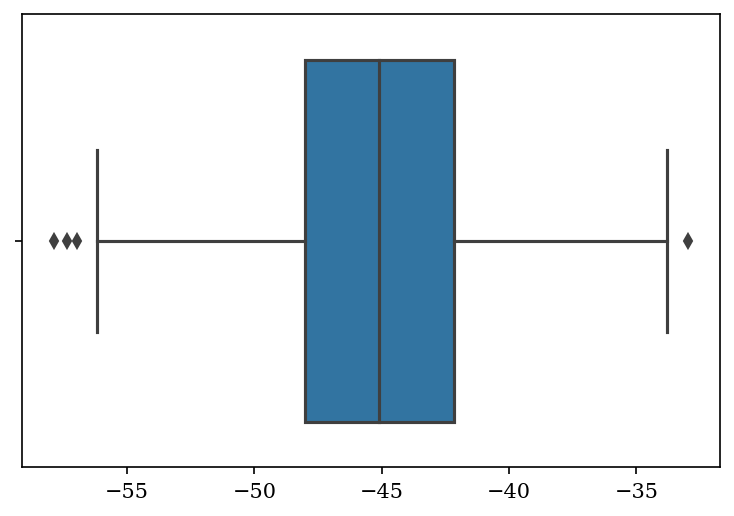

In [11]:
# now, exluding outliers

import seaborn as sns
data = ext_data
sns.displot(data[1][1][-LAST_N:])
plt.show()
sns.boxplot(data[1][1][-LAST_N:])
plt.show()

In [12]:
def outlier_filter(stable_data, time=None):
    if time is None:
        time = np.zeros(stable_data.shape)
    Q1,Q3 = np.percentile(stable_data , [25,75])
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    stable_data_cleaned = stable_data[(stable_data > ll) & (stable_data < ul)]
    time_cleaned = time[(stable_data > ll) & (stable_data < ul)]
    return time_cleaned, stable_data_cleaned

def avg_without_outliers(stable_data):
    return np.mean(outlier_filter(stable_data)[1])
def std_without_outliers(stable_data):
    return np.std(outlier_filter(stable_data)[1])

avg_without_outliers(ext_data[0][1][-LAST_N:])

-45.69061538461543

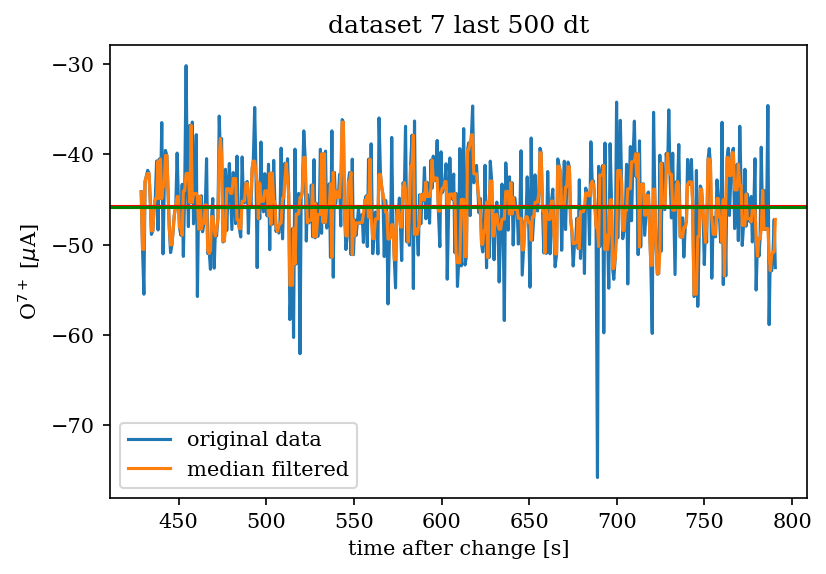

In [13]:
plt.plot(ext_data[0][0][-LAST_N:], ext_data[0][1][-LAST_N:],label= "original data")
plt.plot(ext_data[0][0][-LAST_N:], medfilt(ext_data[0][1][-LAST_N:]), label="median filtered")
plt.axhline(y=avg_without_outliers(ext_data[0][1][-LAST_N:]),c='r')
plt.axhline(y=np.mean(ext_data[0][1][-LAST_N:]),c='g')
plt.title("dataset %d last %d dt"%(i, LAST_N))
plt.xlabel('time after change [s]')
plt.ylabel(labels[2])
plt.legend()
plt.show()

In [14]:
def extract_stable_values(data, last_n=LAST_N):
    # data is a list of (x, y)  tuples, where x is time
    return [avg_without_outliers(trace[1][-LAST_N:]) for trace in data]

def extract_stable_stds(data, last_n=LAST_N):
    # data is a list of (x, y)  tuples, where x is time
    return [std_without_outliers(trace[1][-LAST_N:]) for trace in data]

def stabilization_time(data, start_i=49):
    settle_times = []
    for x, y in data:
        y = medfilt(y, kernel_size=9)
        center = np.mean(y[-LAST_N:])
        std = np.std(y[-LAST_N:])
        ul = center + 6*std
        ll = center - 6*std
        bounds = (ll, ul)
        settle_time = -1
        for i, yi in reversed(list(enumerate(y))[start_i:-LAST_N]):
            if yi < bounds[0] or yi > bounds[1]:
                settle_time = x[i] - x[start_i]
                break
        if settle_time < 0:
            print("WARNING: settle time not found")
            settle_time = 0
        settle_times.append(settle_time)
    return settle_times

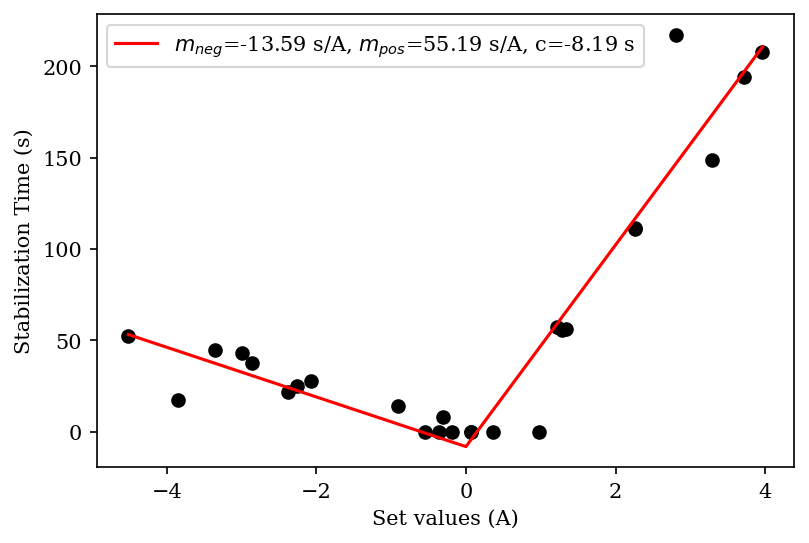

In [15]:
from scipy.optimize import curve_fit

coil = 3 # 3: injection, 4: extraction, 5: mid
data = get_raw_data(coil)
set_values = get_raw_data(coil, 70+coil)

stab_time = np.array(stabilization_time(data))
set_values = np.array(get_set_values(set_values))
plt.scatter(set_values, stab_time, c='black')
plt.xlabel("Set values (A)")
plt.ylabel("Stabilization Time (s)")

# fit with a piece-wise linear function
def linear_model(x, mn, mp, c):
    y = np.piecewise(x, [x < 0, x >= 0], [lambda x: mn * x + c, lambda x: mp * x + c])
    return y

popt, pcov = curve_fit(linear_model, set_values, stab_time) # , sigma=menStd

x_plot = np.linspace(min(set_values), max(set_values), 1000)
plt.plot(x_plot, linear_model(x_plot, *popt), \
    label=r'$m_{neg}$=%.2f s/A, $m_{pos}$=%.2f s/A, c=%.2f s'%tuple(popt), c='r')
plt.legend()
plt.show()

Text(0, 0.5, 'O$^{7+}$ [$\\mu$A]')

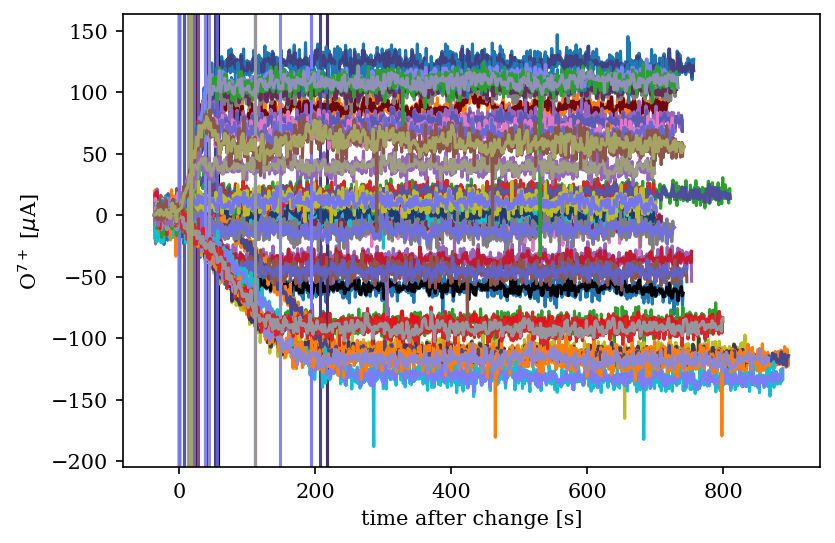

In [16]:
# Stabilization Threshold Visual Check
from matplotlib.pyplot import cm
color = cm.gist_stern(np.linspace(0, 1, 40))

data = get_raw_data(3)
stab_time = stabilization_time(data)
for i, (X, y) in enumerate(inj_data):
    plt.plot(X, y)
    c = color[i]
    plt.plot(X, medfilt(y), c=c)
    plt.axvline(stab_time[i]+X[49], c=c)
    # plt.axvline(X[-LAST_N],c='b')
plt.xlabel('time after change [s]')
plt.ylabel(labels[2])